# Let's Grow your Own Inner Core!

### Choose a model in the list: 
    - geodyn_trg.TranslationGrowthRotation()
    - geodyn_static.Hemispheres()

### Choose a proxy type:
    - age
    - position
    - phi
    - theta
    - growth rate

### set the parameters for the model : geodynModel.set_parameters(parameters)
### set the units : geodynModel.define_units()

### Choose a data set:
    - data.SeismicFromFile(filename) # Lauren's data set
    - data.RandomData(numbers_of_points)
    - data.PerfectSamplingEquator(numbers_of_points)
        organized on a cartesian grid. numbers_of_points is the number of points along the x or y axis. The total number of points is numbers_of_points**2*pi/4
        - as a special plot function to show streamlines: plot_c_vec(self,modelgeodyn)
    - data.PerfectSamplingEquatorRadial(Nr, Ntheta)
        same than below, but organized on a polar grid, not a cartesian grid.


### Extract the info:
    - calculate the proxy value for all points of the data set: geodyn.evaluate_proxy(data_set, geodynModel)
    - extract the positions as numpy arrays: extract_rtp or extract_xyz
    - calculate other variables: positions.angular_distance_to_point(t,p, t_point, p_point)

In [1]:
%matplotlib inline

# import statements
import numpy as np
import matplotlib.pyplot as plt #for figures
from mpl_toolkits.basemap import Basemap #to render maps
import math
import json #to write dict with parameters

from GrowYourIC import positions, geodyn, geodyn_trg, geodyn_static, plot_data, data

plt.rcParams['figure.figsize'] = (8.0, 3.0) #size of figures
cm = plt.cm.get_cmap('viridis')
cm2 = plt.cm.get_cmap('winter')

/Users/marine/.python-eggs/GrowYourIC-0.5-py3.5.egg-tmp/GrowYourIC/data/CM2008_data.mat


## Define the geodynamical model

Un-comment one of the model

In [2]:
## un-comment one of them
geodynModel = geodyn_trg.TranslationGrowthRotation() #can do all the models presented in the paper
# geodynModel = geodyn_static.Hemispheres() #this is a static model, only hemispheres. 

Change the values of the parameters to get the model you want (here, parameters for .TranslationGrowthRotation())

In [3]:
age_ic_dim = 1e9 #in years
rICB_dim = 1221. #in km
v_g_dim = rICB_dim/age_ic_dim # in km/years #growth rate
print("Growth rate is {:.2e} km/years".format(v_g_dim))
v_g_dim_seconds = v_g_dim*1e3/(np.pi*1e7)

translation_velocity_dim = 0.8*v_g_dim_seconds#4e-10 #0.8*v_g_dim_seconds#4e-10 #m.s, value for today's Earth with Q_cmb = 10TW (see Alboussiere et al. 2010)
time_translation = rICB_dim*1e3/translation_velocity_dim /(np.pi*1e7)
maxAge = 2.*time_translation/1e6
print("The translation recycles the inner core material in {0:.2e} million years".format(maxAge))
print("Translation velocity is {0:.2e} km/years".format(translation_velocity_dim*np.pi*1e7/1e3))

units = None #we give them already dimensionless parameters. 
rICB = 1.
age_ic = 1.
omega = 0.#0.5*np.pi/200e6*age_ic_dim#0.5*np.pi #0. #0.5*np.pi/200e6*age_ic_dim# 0.#0.5*np.pi#0.#0.5*np.pi/200e6*age_ic_dim #0. #-0.5*np.pi # Rotation rates has to be in ]-np.pi, np.pi[
print("Rotation rate is {:.2e}".format(omega))
velocity_amplitude = translation_velocity_dim*age_ic_dim*np.pi*1e7/rICB_dim/1e3
velocity_center = [0., 100.]#center of the eastern hemisphere
velocity = geodyn_trg.translation_velocity(velocity_center, velocity_amplitude)
exponent_growth = 1.#0.1#1

print(v_g_dim, velocity_amplitude, omega/age_ic_dim*180/np.pi*1e6)

Growth rate is 1.22e-06 km/years
The translation recycles the inner core material in 2.50e+03 million years
Translation velocity is 9.77e-07 km/years
Rotation rate is 0.00e+00
1.221e-06 0.7999999999999999 0.0


Define a proxy type, and a proxy name (to be used in the figures to annotate the axes)

You can re-define it later if you want (or define another proxy_type2 if needed)

In [4]:
proxy_type = "age"#"growth rate"
proxy_name = "age (Myears)" #growth rate (km/Myears)"
proxy_lim = [0, maxAge] #or None
#proxy_lim = None

fig_name = "figures/test_" #to name the figures

print(rICB, age_ic, velocity_amplitude, omega, exponent_growth,  proxy_type)
print(velocity)

1.0 1.0 0.7999999999999999 0.0 1.0 age
[ -1.38918542e-01   7.87846202e-01   4.89858720e-17]


### Parameters for the geodynamical model

This will input the different parameters in the model.

In [5]:
parameters = dict({'units': units,
              'rICB': rICB, 
              'tau_ic':age_ic,
              'vt': velocity,
              'exponent_growth': exponent_growth,
              'omega': omega,
              'proxy_type': proxy_type})
geodynModel.set_parameters(parameters)
geodynModel.define_units()

param = parameters
param['vt'] = parameters['vt'].tolist() #for json serialization
# write file with parameters, readable with json, byt also human-readable
with open(fig_name+'parameters.json', 'w') as f:
    json.dump(param, f)
    
print(parameters)

{'exponent_growth': 1.0, 'vt': [-0.13891854213354424, 0.7878462024097663, 4.8985871965894125e-17], 'proxy_type': 'age', 'omega': 0.0, 'tau_ic': 1.0, 'units': None, 'rICB': 1.0}


## Different data set and visualisations

### Perfect sampling at the equator (to visualise the flow lines)

You can add more points to get a better precision.

===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model is Translation, Rotation and Growth
= Proxy is age
= Data set is Perfect sampling in the equatorial plane
= Proxy is evaluated for bt_point
= Number of points to examine: 60
===


/usr/local/lib/python3.5/site-packages/scipy/integrate/_ode.py:1095: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/usr/local/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


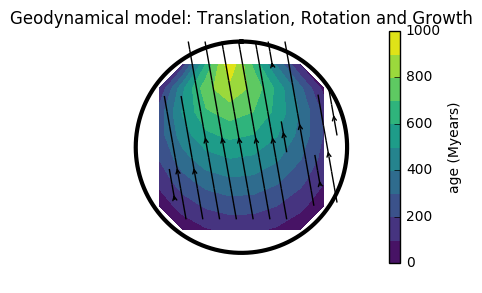

In [6]:
npoints = 10 #number of points in the x direction for the data set. 
data_set = data.PerfectSamplingEquator(npoints, rICB = 1.)
data_set.method = "bt_point"
proxy = geodyn.evaluate_proxy(data_set, geodynModel, proxy_type="age", verbose = False)
data_set.plot_c_vec(geodynModel, proxy=proxy, cm=cm, nameproxy="age (Myears)")
plt.savefig(fig_name+"equatorial_plot.pdf", bbox_inches='tight')

### Perfect sampling in the first 100km (to visualise the depth evolution)

===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model is Translation, Rotation and Growth
= Proxy is age
= Data set is Meshgrid at the equator between 0 and 120km depth
= Proxy is evaluated for bt_point
= Number of points to examine: 100
===


/usr/local/lib/python3.5/site-packages/scipy/integrate/_ode.py:1095: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/usr/local/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/local/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


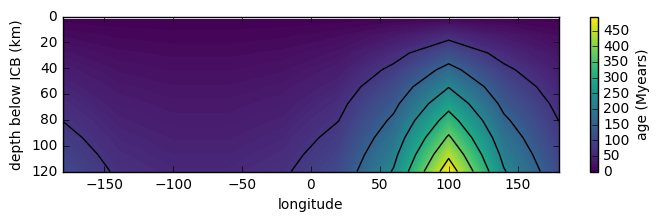

In [7]:
data_meshgrid = data.Equator_upperpart(10,10)
data_meshgrid.method = "bt_point"
proxy_meshgrid = geodyn.evaluate_proxy(data_meshgrid, geodynModel, proxy_type=proxy_type, verbose = False)
#r, t, p = data_meshgrid.extract_rtp("bottom_turning_point")

fig3, ax3 = plt.subplots(figsize=(8, 2))
X, Y, Z  = data_meshgrid.mesh_RPProxy(proxy_meshgrid)
sc = ax3.contourf(Y, rICB_dim*(1.-X), Z, 100, cmap=cm)
sc2 = ax3.contour(sc, levels=sc.levels[::15], colors = "k")
ax3.set_ylim(-0, 120)
fig3.gca().invert_yaxis()
ax3.set_xlim(-180,180)
cbar = fig3.colorbar(sc)
#cbar.set_clim(0, maxAge)
cbar.set_label(proxy_name)
ax3.set_xlabel("longitude")
ax3.set_ylabel("depth below ICB (km)")

plt.savefig(fig_name+"meshgrid.pdf", bbox_inches='tight')

===
== Evaluate value of proxy for all points of the data set 
= Geodynamic model is Translation, Rotation and Growth
= Proxy is age
= Data set is Perfect sampling at the surface
= Proxy is evaluated for bt_point
= Number of points to examine: 400
===


/usr/local/lib/python3.5/site-packages/scipy/integrate/_ode.py:1095: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

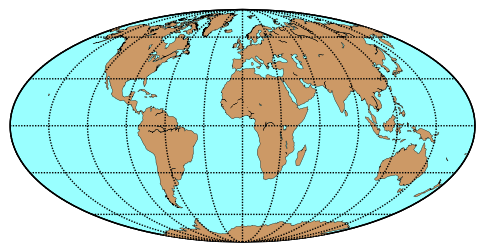

In [8]:
npoints = 20 #number of points in the x direction for the data set. 
data_set = data.PerfectSamplingSurface(npoints, rICB = 1., depth=0.01)
data_set.method = "bt_point"
proxy_surface = geodyn.evaluate_proxy(data_set, geodynModel, proxy_type=proxy_type, verbose = False)
#r, t, p = data_set.extract_rtp("bottom_turning_point")
X, Y, Z  = data_set.mesh_TPProxy(proxy_surface)

## map
m, fig = plot_data.setting_map()


y, x = m(Y, X)
sc = m.contourf(y, x, Z, 30, cmap=cm, zorder=2, edgecolors='none')
plt.title("Dataset: {},\n geodynamic model: {}".format(data_set.name, geodynModel.name))
cbar = plt.colorbar(sc)
cbar.set_label(proxy_name)
fig.savefig(fig_name+"map_surface.pdf", bbox_inches='tight')

### Random data set, in the first 100km  - bottom turning point only

#### Calculate the data

In [ ]:
# random data set
data_set_random = data.RandomData(300)
data_set_random.method = "bt_point"

proxy_random = geodyn.evaluate_proxy(data_set_random, geodynModel, proxy_type=proxy_type, verbose=False)
data_path = "../GrowYourIC/data/"
geodynModel.data_path = data_path

if proxy_type == "age":
#    ## domain size and Vp
    proxy_random_size = geodyn.evaluate_proxy(data_set_random, geodynModel, proxy_type="domain_size", verbose=False)
    proxy_random_dV = geodyn.evaluate_proxy(data_set_random, geodynModel, proxy_type="dV_V", verbose=False)

In [ ]:
r, t, p = data_set_random.extract_rtp("bottom_turning_point")
dist = positions.angular_distance_to_point(t, p, *velocity_center)

## map
m, fig = plot_data.setting_map() 
x, y = m(p, t)
sc = m.scatter(x, y, c=proxy_random,s=8, zorder=10, cmap=cm, edgecolors='none')
plt.title("Dataset: {},\n geodynamic model: {}".format(data_set_random.name, geodynModel.name))
cbar = plt.colorbar(sc)
cbar.set_label(proxy_name)
fig.savefig(fig_name+data_set_random.shortname+"_map.pdf", bbox_inches='tight')

## phi and distance plots
fig, ax = plt.subplots(2,2, figsize=(8.0, 5.0))
sc1 = ax[0,0].scatter(p, proxy_random, c=abs(t),s=3, cmap=cm2, vmin =-0, vmax =90, linewidth=0)
phi = np.linspace(-180,180, 50)
#analytic_equator = np.maximum(2*np.sin((phi-10)*np.pi/180.)*rICB_dim*1e3/translation_velocity_dim /(np.pi*1e7)/1e6,0.)
#ax[0,0].plot(phi,analytic_equator, 'r', linewidth=2)
ax[0,0].set_xlabel("longitude")
ax[0,0].set_ylabel(proxy_name)
if proxy_lim is not None:
    ax[0,0].set_ylim(proxy_lim)
sc2 = ax[0,1].scatter(dist, proxy_random, c=abs(t), cmap=cm2, vmin=-0, vmax =90, s=3, linewidth=0)
ax[0,1].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
phi = np.linspace(-90,90, 100)
if proxy_type == "age":
    analytic_equator = np.maximum(2*np.sin((phi-10)*np.pi/180.)*rICB_dim*1e3/translation_velocity_dim /(np.pi*1e7)/1e6,0.)
    ax[0,0].plot(phi,analytic_equator, 'r', linewidth=2)
    analytic_equator = np.maximum(2*np.sin((-phi)*np.pi/180.)*rICB_dim*1e3/translation_velocity_dim /(np.pi*1e7)/1e6,0.)
    ax[0,1].plot(phi+90,analytic_equator, 'r', linewidth=2)
ax[0,1].set_xlim([0,180])
ax[0,0].set_xlim([-180,180])
cbar = fig.colorbar(sc1)
cbar.set_label("longitude: abs(theta)")
if proxy_lim is not None:
    ax[0,1].set_ylim(proxy_lim)
## figure with domain size and Vp
if proxy_type == "age":
    sc3 = ax[1,0].scatter(dist, proxy_random_size, c=abs(t), cmap=cm2, vmin =-0, vmax =90, s=3, linewidth=0)
    ax[1,0].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
    ax[1,0].set_ylabel("domain size (m)")
    ax[1,0].set_xlim([0,180])
    ax[1,0].set_ylim([0, 2500.000])
    sc4 = ax[1,1].scatter(dist, proxy_random_dV, c=abs(t), cmap=cm2, vmin=-0, vmax =90, s=3, linewidth=0)
    ax[1,1].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
    ax[1,1].set_ylabel("dV/V")
    ax[1,1].set_xlim([0,180])
    ax[1,1].set_ylim([-0.017, -0.002])
fig.savefig(fig_name +data_set_random.shortname+ '_long_dist.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(8, 2))
sc=ax.scatter(p,rICB_dim*(1.-r), c=proxy_random, s=10,cmap=cm, linewidth=0)
ax.set_ylim(-0,120)
fig.gca().invert_yaxis()
ax.set_xlim(-180,180)
cbar = fig.colorbar(sc)
if proxy_lim is not None:
    cbar.set_clim(0, maxAge)
ax.set_xlabel("longitude")
ax.set_ylabel("depth below ICB (km)")
cbar.set_label(proxy_name)

fig.savefig(fig_name+data_set_random.shortname+"_depth.pdf", bbox_inches='tight')

### Real Data set from Waszek paper

In [ ]:
## real data set
data_set = data.SeismicFromFile("../GrowYourIC/data/WD11.dat")
data_set.method = "bt_point"
 
proxy2 = geodyn.evaluate_proxy(data_set, geodynModel, proxy_type=proxy_type, verbose=False)

if proxy_type == "age":
## domain size and DV/V
    proxy_size = geodyn.evaluate_proxy(data_set, geodynModel, proxy_type="domain_size", verbose=False)
    proxy_dV = geodyn.evaluate_proxy(data_set, geodynModel, proxy_type="dV_V", verbose=False)

In [ ]:
r, t, p = data_set.extract_rtp("bottom_turning_point")
dist = positions.angular_distance_to_point(t, p, *velocity_center)

## map
m, fig = plot_data.setting_map() 
x, y = m(p, t)
sc = m.scatter(x, y, c=proxy2,s=8, zorder=10, cmap=cm, edgecolors='none')
plt.title("Dataset: {},\n geodynamic model: {}".format(data_set.name, geodynModel.name))
cbar = plt.colorbar(sc)
cbar.set_label(proxy_name)
fig.savefig(fig_name+data_set.shortname+"_map.pdf", bbox_inches='tight')

## phi and distance plots
fig, ax = plt.subplots(2,2, figsize=(8.0, 5.0))
sc1 = ax[0,0].scatter(p, proxy2, c=abs(t),s=3, cmap=cm2, vmin =-0, vmax =90, linewidth=0)
phi = np.linspace(-180,180, 50)
#analytic_equator = np.maximum(2*np.sin((phi-10)*np.pi/180.)*rICB_dim*1e3/translation_velocity_dim /(np.pi*1e7)/1e6,0.)
#ax[0,0].plot(phi,analytic_equator, 'r', linewidth=2)
ax[0,0].set_xlabel("longitude")
ax[0,0].set_ylabel(proxy_name)
if proxy_lim is not None:
    ax[0,0].set_ylim(proxy_lim)
sc2 = ax[0,1].scatter(dist, proxy2, c=abs(t), cmap=cm2, vmin=-0, vmax =90, s=3, linewidth=0)
ax[0,1].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
phi = np.linspace(-90,90, 100)
if proxy_type == "age":
    analytic_equator = np.maximum(2*np.sin((-phi)*np.pi/180.)*rICB_dim*1e3/translation_velocity_dim /(np.pi*1e7)/1e6,0.)
    ax[0,1].plot(phi+90,analytic_equator, 'r', linewidth=2)
    analytic_equator = np.maximum(2*np.sin((phi-10)*np.pi/180.)*rICB_dim*1e3/translation_velocity_dim /(np.pi*1e7)/1e6,0.)
    ax[0,0].plot(phi,analytic_equator, 'r', linewidth=2)
ax[0,1].set_xlim([0,180])
ax[0,0].set_xlim([-180,180])
cbar = fig.colorbar(sc1)
cbar.set_label("longitude: abs(theta)")
if proxy_lim is not None:
    ax[0,1].set_ylim(proxy_lim)
## figure with domain size and Vp
if proxy_type == "age":
    sc3 = ax[1,0].scatter(dist, proxy_size, c=abs(t), cmap=cm2, vmin =-0, vmax =90, s=3, linewidth=0)
    ax[1,0].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
    ax[1,0].set_ylabel("domain size (m)")
    ax[1,0].set_xlim([0,180])
    ax[1,0].set_ylim([0, 2500.000])
    sc4 = ax[1,1].scatter(dist, proxy_dV, c=abs(t), cmap=cm2, vmin=-0, vmax =90, s=3, linewidth=0)
    ax[1,1].set_xlabel("angular distance to ({}, {})".format(*velocity_center))
    ax[1,1].set_ylabel("dV/V")
    ax[1,1].set_xlim([0,180])
    ax[1,1].set_ylim([-0.017, -0.002])
fig.savefig(fig_name + data_set.shortname+'_long_dist.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize=(8, 2))
sc=ax.scatter(p,rICB_dim*(1.-r), c=proxy2, s=10,cmap=cm, linewidth=0)
ax.set_ylim(-0,120)
fig.gca().invert_yaxis()
ax.set_xlim(-180,180)
cbar = fig.colorbar(sc)
if proxy_lim is not None:
    cbar.set_clim(0, maxAge)
ax.set_xlabel("longitude")
ax.set_ylabel("depth below ICB (km)")
cbar.set_label(proxy_name)

fig.savefig(fig_name+data_set.shortname+"_depth.pdf", bbox_inches='tight')